In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('activation_diff_results2.csv')

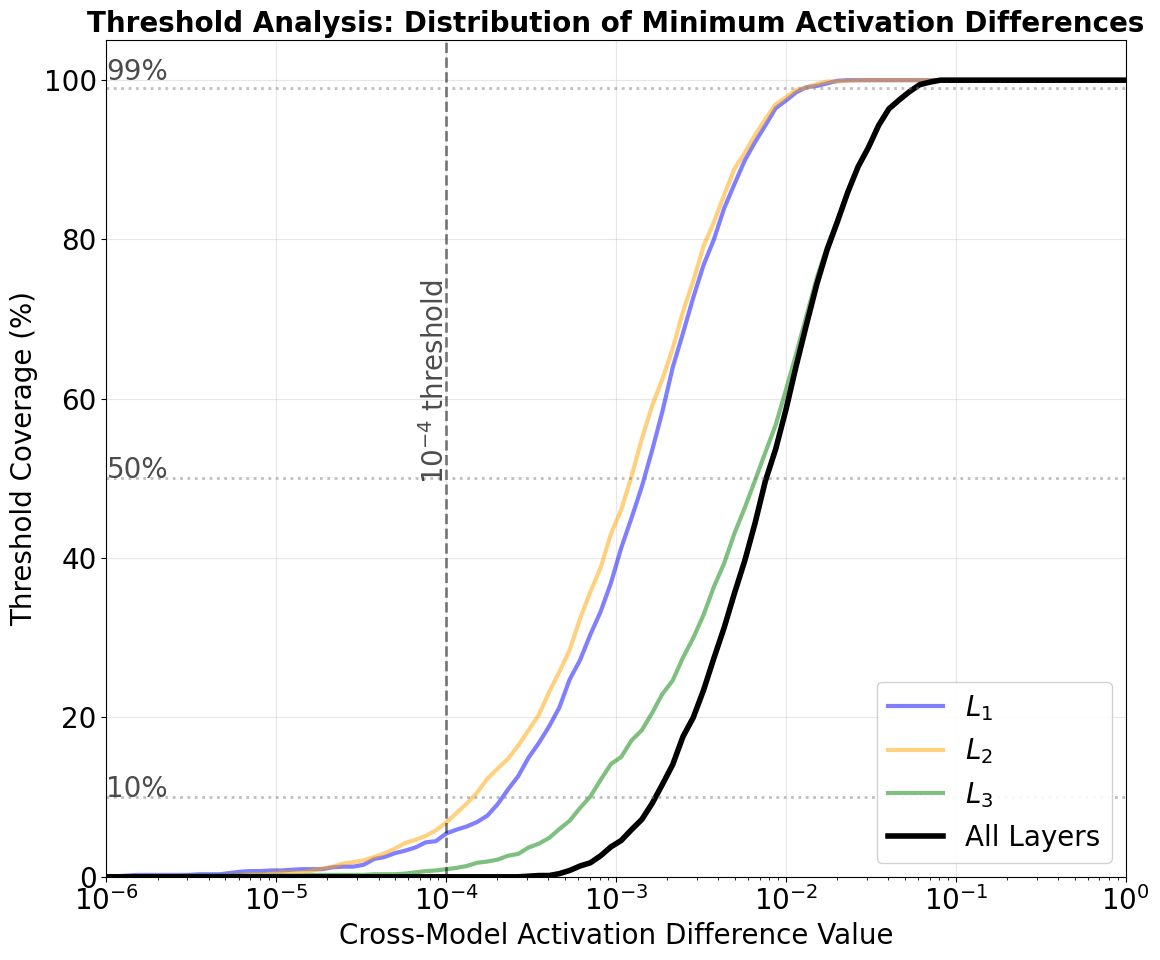


Percentage passing at key thresholds:

Threshold = 0.0001:
--------------------------------------------------
  FC1: 5.4%
  FC2: 6.8%
  FC3: 1.0%
  All Layers: 0.0%

Threshold = 0.001:
--------------------------------------------------
  FC1: 38.8%
  FC2: 44.6%
  FC3: 14.6%
  All Layers: 4.1%

Threshold = 0.01:
--------------------------------------------------
  FC1: 97.4%
  FC2: 97.8%
  FC3: 61.1%
  All Layers: 58.6%

Threshold = 0.1:
--------------------------------------------------
  FC1: 100.0%
  FC2: 100.0%
  FC3: 100.0%
  All Layers: 100.0%


In [15]:
# Set global font size
plt.rcParams.update({'font.size': 20})

# Define threshold values to test
thresholds = np.logspace(-6, 0, 100)  # From 1e-6 to 1 (0.000001 to 1)

# Create single plot figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Define layers
layers = ['fc1', 'fc2', 'fc3']

layer_labels = {
    'fc1': r'$L_1$',
    'fc2': r'$L_2$', 
    'fc3': r'$L_3$'
}


# Define colors for each layer
layer_colors = {
    'fc1': 'blue',
    'fc2': 'orange', 
    'fc3': 'green'
}

# Define layer alphas for visual distinction
layer_alphas = {'fc1': 0.5, 'fc2': 0.5, 'fc3': 0.5}

# Plot minimum values for each layer
for layer in layers:
    column = f'{layer}_min_abs_diff'
    values = df[column].values
    
    # Calculate percentage passing each threshold
    percentages = []
    for threshold in thresholds:
        passing = np.sum(values <= threshold) / len(values) * 100
        percentages.append(passing)
    
    # Plot cumulative distribution
    ax.semilogx(thresholds, percentages, 
               label=layer_labels[layer],
               color=layer_colors[layer],
               linewidth=3, 
               alpha=layer_alphas[layer])

# Plot the all-layers line (worst case - ALL layers must pass)
percentages_all = []
for threshold in thresholds:
    passing_count = 0
    for idx in df.index:
        row = df.loc[idx]
        # Check if all layers pass for this sample
        all_pass = True
        for layer in layers:
            if row[f'{layer}_min_abs_diff'] > threshold:
                all_pass = False
                break
        if all_pass:
            passing_count += 1
    
    percentage = (passing_count / len(df)) * 100
    percentages_all.append(percentage)

ax.semilogx(thresholds, percentages_all, 
           label='All Layers',
           color='black',
           linewidth=4,
           alpha=1.0)

# Add reference lines
ax.axvline(x=0.0001, color='black', linestyle='--', alpha=0.5, linewidth=2)
ax.axhline(y=10, color='gray', linestyle=':', alpha=0.5, linewidth=2)
ax.axhline(y=50, color='gray', linestyle=':', alpha=0.5, linewidth=2)
ax.axhline(y=99, color='gray', linestyle=':', alpha=0.5, linewidth=2)

# Add text labels
ax.text(0.00007, 50, r'$10^{-4}$ threshold', rotation=90, fontsize=20, alpha=0.7)
ax.text(1e-6, 10, '10%', fontsize=20, alpha=0.7)
ax.text(1e-6, 50, '50%', fontsize=20, alpha=0.7)
ax.text(1e-6, 100, '99%', fontsize=20, alpha=0.7)

ax.set_xlabel('Cross-Model Activation Difference Value', fontsize=20)
ax.set_ylabel('Threshold Coverage (%)', fontsize=20)
ax.set_title('Threshold Analysis: Distribution of Minimum Activation Differences', fontsize=20, 
             fontweight='bold')

# Create legend
ax.legend(fontsize=20, 
          loc='lower right',
          framealpha=0.9)

ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
ax.set_xlim(1e-6, 1)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.savefig('DCA-SQ1.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics at key thresholds
print("\nPercentage passing at key thresholds:")
print("=" * 70)
key_thresholds = [0.0001, 0.001, 0.01, 0.1]

for threshold in key_thresholds:
    print(f"\nThreshold = {threshold}:")
    print("-" * 50)
    
    for layer in layers:
        column = f'{layer}_min_abs_diff'
        values = df[column].values
        percentage = np.sum(values <= threshold) / len(values) * 100
        print(f"  {layer.upper()}: {percentage:.1f}%")
    
    # All layers simultaneous
    passing_count = 0
    for idx in df.index:
        row = df.loc[idx]
        all_pass = all(row[f'{layer}_min_abs_diff'] <= threshold for layer in layers)
        if all_pass:
            passing_count += 1
    percentage = (passing_count / len(df)) * 100
    print(f"  All Layers: {percentage:.1f}%")


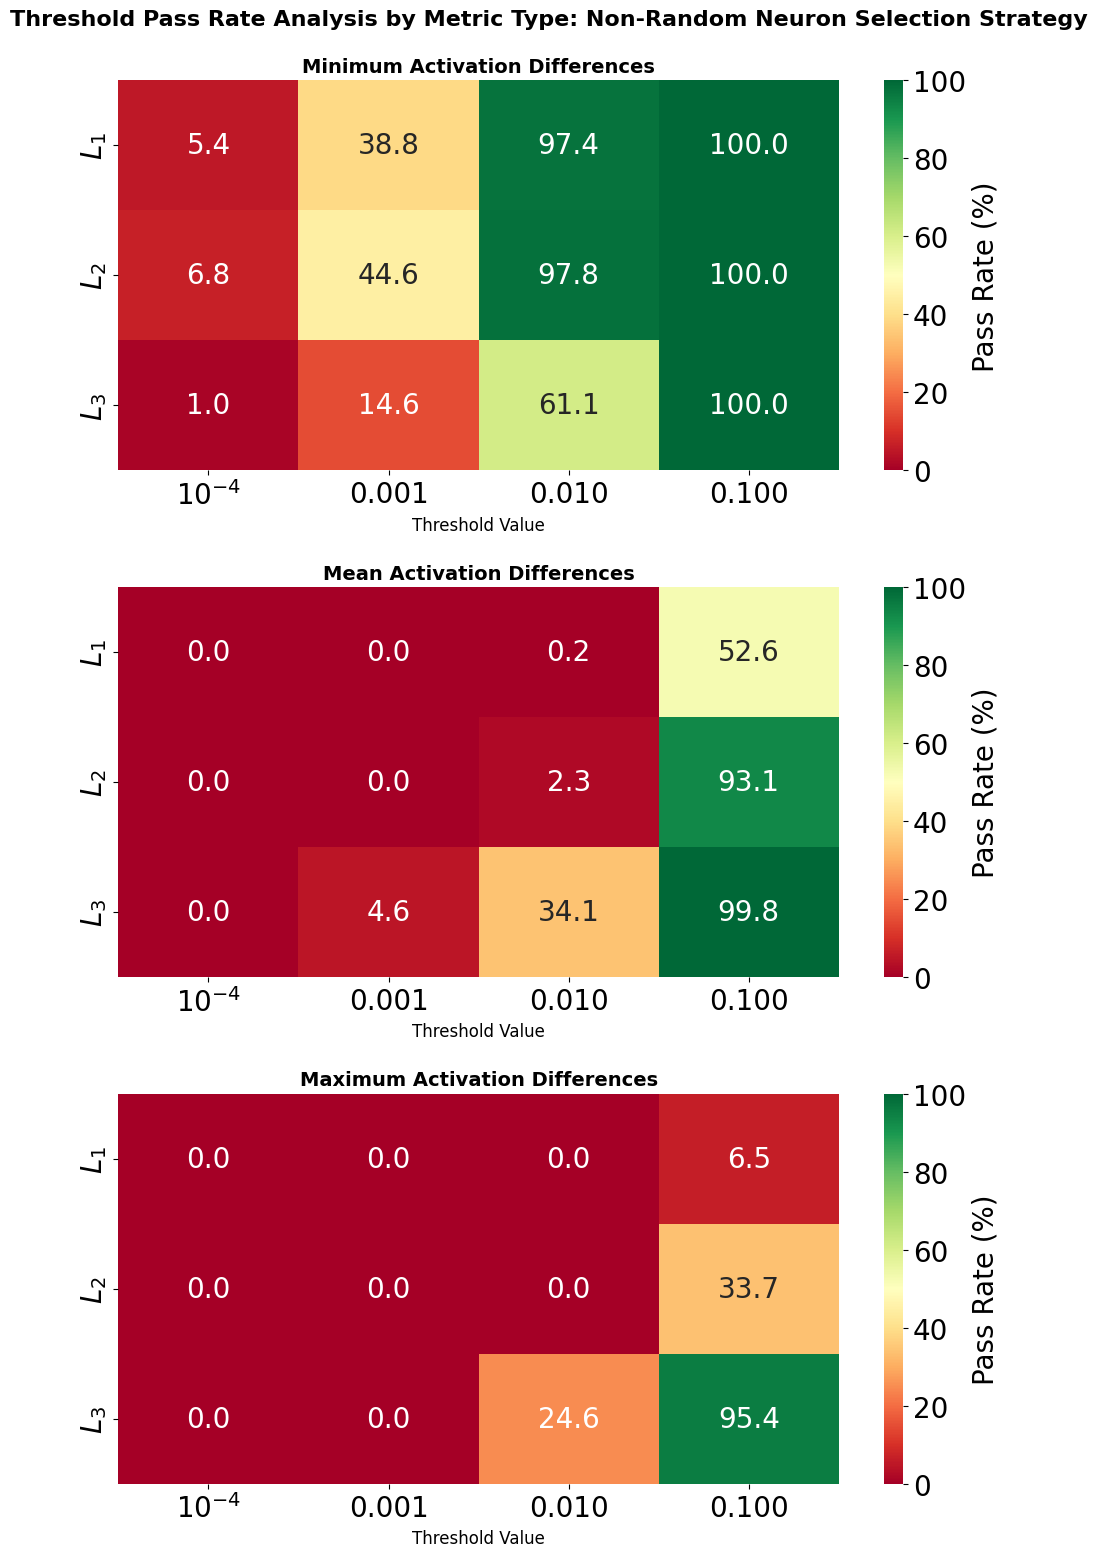

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the results
results = pd.read_csv('activation_diff_results2.csv')

# Define threshold values to test
thresholds = np.logspace(-6, 0, 100)  # From 1e-6 to 1

# Create figure with 1x3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 16))
fig.suptitle('Threshold Pass Rate Analysis by Metric Type: Non-Random Neuron Selection Strategy', 
             fontsize=16, fontweight='bold')

layers = ['fc1', 'fc2', 'fc3']
metrics = ['min_abs_diff', 'mean_abs_diff', 'max_abs_diff']
metric_titles = ['Minimum Activation Differences', 'Mean Activation Differences', 'Maximum Activation Differences']
threshold_values = [0.0001, 0.001, 0.01, 0.1]

layer_labels = {
    'fc1': r'$L_1$',
    'fc2': r'$L_2$', 
    'fc3': r'$L_3$'
}
def format_percentile_not_bold(val):
    if val < 0.001:
        exponent = int(np.floor(np.log10(abs(val))))
        mantissa = val / (10 ** exponent)
        return f"$ 10^{{{exponent}}}$"#{mantissa:.2f} \\times
    elif val < 0.1:
        return f"{val:.3f}"
    else:
        return f"{val:.3f}"
# Function to create heatmap data
def create_heatmap_data(metric_name):
    heatmap_data = []
    for layer in layers:
        column = f'{layer}_{metric_name}'
        values = results[column].values
        
        pass_rates = []
        for threshold in threshold_values:
            passing = np.sum(values <= threshold) / len(values) * 100
            pass_rates.append(passing)
        
        heatmap_data.append(pass_rates)
    
    return np.array(heatmap_data)

# Create heatmaps for each metric
for idx, (metric, title) in enumerate(zip(metrics, metric_titles)):
    ax = axes[idx]
    
    # Create heatmap data
    heatmap_data = create_heatmap_data(metric)
    
    # Create heatmap
    sns.heatmap(heatmap_data, 
                xticklabels=[f'{format_percentile_not_bold(t)}' for t in threshold_values],
                yticklabels=[f'{layer_labels[layer]}' for layer in layers],
                annot=True, fmt='.1f', cmap='RdYlGn',
                cbar_kws={'label': 'Pass Rate (%)'}, 
                vmin=0, vmax=100, ax=ax)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Threshold Value', fontsize=12)
    
    # Only add y-label to the first subplot
    if idx == 0:
        #ax.set_ylabel('Layer', fontsize=12)
        pass
    else:
        ax.set_ylabel('')

plt.tight_layout()
save_path = 'TPR-SQ1.pdf'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
